## Easy Experiment .ipynb File

# <font color='red'><b> 🐬 기억합시다 :] 실험마다 인덱스 붙여서 파일 새로만들기~! <b></font>

# train

## import

In [2]:
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torch.nn.functional as F

import random
import time
from datetime import timedelta

import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


import multiprocessing
import timm

from PIL import Image

import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

In [4]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [5]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

## configuration

In [6]:
### cofiguration
seed = 42
check_point_dir_name = 'convnext_tiny'

data_dir = './dataset/train/images/'
train_csv_path = './dataset/train/custom_train.csv'
save_dir = f'./checkpoints/{check_point_dir_name}'

train_b_size = 32
valid_b_size = 500
train_ratio = 0.7
epochs = 30
print_interval = 414
lr = 3e-4
model_name = 'convnext_tiny'
num_labels = 18
loss_function_name = 'CrossEntropyLoss' # ex FocalLoss, CrossEntropyLoss
optimizer_name = 'AdamW'
weight_decay = 0.02
scheduler_name = 'CosineAnnealingWarmRestarts'
comment = f'스케줄러 변경'


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


seed_everything(seed)

In [5]:
train_df = pd.read_csv(train_csv_path)
imgs_path = train_df['path'] 
labels = train_df['class'] # input your label feature
stratify_col = train_df['class']

train_paths, valid_paths, train_labels, valid_labels = train_test_split(imgs_path, labels,
                                                                        train_size=0.7,
                                                                        shuffle=True,
                                                                        random_state=seed,
                                                                        stratify=stratify_col)

In [6]:
os.makedirs(save_dir,exist_ok=True)

In [7]:

dict_args = {
'seed' : seed,
'train_b_size': train_b_size,
'epochs' : epochs,
'lr' : lr,
'model_name' : model_name,
'num_labels' : num_labels,
'train_ratio': train_ratio,
'loss_function_name' : loss_function_name,
'optimizer_name' : optimizer_name,
'weight_decay' : weight_decay,
'scheduler_name' : scheduler_name,
'comment' : comment
}

In [8]:
with open(os.path.join(save_dir, 'config.json'), 'w', encoding='utf-8') as f:
        json.dump(dict_args, f, ensure_ascii=False, indent=4)

## datasets class

In [9]:
class CustomTrainDataset(Dataset):
    ## input pd.Series
    ## output np.ndarray
    ## change dummy, if label_col is 'gender' or 'mask_state'
    def __init__(self, img_paths : pd.Series, labels : pd.Series, label_col='class', transforms=None):
        self.img_paths = img_paths.to_numpy()
        self.transforms = transforms
        if label_col == 'gender':
            self.labels = pd.get_dummies(labels).to_numpy()
        elif label_col == 'mask_state':
            self.labels = pd.get_dummies(labels).to_numpy()
        else: # age, classes
            self.labels = labels.to_numpy()
        ## if (False), assert occur
        assert self.transforms is not None, 'you must use transforms in Trainset'
    
    ## return numpy img, label
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = np.array(Image.open(img_path))

        img = self.transforms(image=img)["image"]
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

## augmentations

In [10]:
train_transforms = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.GridDistortion(p=0.5),
        A.CLAHE(),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])
    
valid_transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
        ToTensorV2()
    ])

## make dataset and dataloader

In [11]:
train_dset = CustomTrainDataset(train_paths, train_labels, 'class', train_transforms)
val_dset = CustomTrainDataset(valid_paths, valid_labels, 'class', valid_transforms)

In [12]:
train_loader = DataLoader(
        train_dset,
        batch_size=train_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=True,
        pin_memory=use_cuda,
        drop_last=False,
    )

val_loader = DataLoader(
        val_dset,
        batch_size=valid_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=True,
    )

## visualization transform

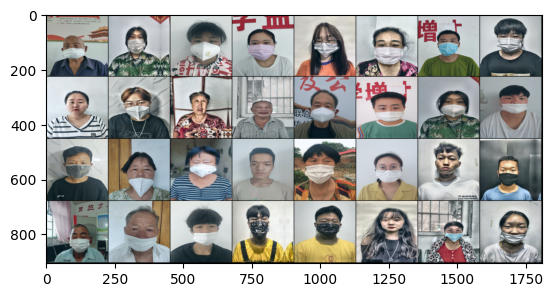

In [13]:
## for check transform
imgs, labels = next(iter(train_loader))
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()

## Model

In [14]:
model = timm.create_model(model_name=model_name, pretrained=True, num_classes=num_labels)
model.to(device)
model = torch.nn.DataParallel(model)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /opt/ml/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


## Loss function

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

class F1Loss(nn.Module):
    def __init__(self, classes=18, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()

In [16]:
if loss_function_name == 'CrossEntropyLoss':
    criterion = nn.CrossEntropyLoss()
elif loss_function_name == 'FocalLoss':
    criterion = FocalLoss()
elif loss_function_name == 'F1Loss':
    criterion = F1Loss(classes=num_labels)
else:
    raise ValueError(f'not implement Loss function : {loss_function_name}')

## Optimizer

In [17]:
# if you param freeze, not update during training
optimizer = None
if optimizer_name == 'AdamW':
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay) # 0.09 
else:
    raise ValueError(f'not implement Optimizer : {optimizer_name}')

## Scheduler  

In [18]:
scheduler = None

if scheduler_name == 'ReduceLROnPlateau':
    ## during 5epochs, valid loss decrease 1e-3↓, lr update lr*0.5
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=1e-3) ## 정리
elif scheduler_name == 'CosineAnnealingWarmRestarts':
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=1e-4)

assert scheduler != None , 'sheduler is None'

## Train

In [19]:
best_val_acc = 0
best_val_f1 = 0
best_val_loss = np.Inf

list_total_preds = [] # full_preds
list_total_labels = [] # full_labels

start=time.process_time()

for epoch in range(epochs):
    model.train()

    epoch_loss = 0
    epoch_preds = []
    epoch_labels = []

    iter_preds = []
    iter_labels = []

    for idx, train_batch in enumerate(train_loader):
        b_imgs, b_labels = train_batch # batch imgs and batch labels
        b_imgs = b_imgs.to(device)
        b_labels = b_labels.to(device)

        b_logits = model(b_imgs)
        b_loss = criterion(b_logits, b_labels)
        b_preds = torch.argmax(b_logits, dim=-1)

        optimizer.zero_grad()
        b_loss.backward()
        optimizer.step()

        epoch_loss += b_loss.item()
        epoch_preds += b_preds.detach().cpu().numpy().tolist()
        epoch_labels += b_labels.detach().cpu().numpy().tolist()

        # print interval batch
        if(idx+1) % print_interval == 0:
            current_loss = epoch_loss / (idx+1) # / batch
            correct_list = [i==j for i,j in zip(epoch_preds, epoch_labels)]
            current_acc = sum(correct_list) / len(correct_list)
            epoch_train_f1 = f1_score(epoch_labels, epoch_preds, average='macro')
            print(
                    f"Epoch[{epoch+1}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                    f"training loss {current_loss:2.4f} || training acc {current_acc:4.2%} || train f1 {epoch_train_f1:2.4f} || "
                    f"lr {optimizer.param_groups[0]['lr']:.5f}"
                )
    scheduler.step()
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval()

        val_loss = []
        val_acc = []

        val_preds = [] # every data's preds
        val_labels = [] # every data's label

        for idx, val_batch in enumerate(val_loader):
            imgs, labels = val_batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            b_loss = criterion(logits, labels).item()
            
            preds = torch.argmax(logits, dim=-1)

            correct_num = (labels == preds).sum().item()

            val_loss.append(b_loss)
            val_acc.append(correct_num)

            val_preds += preds.detach().cpu().numpy().tolist()
            val_labels += labels.detach().cpu().numpy().tolist()

            

        epoch_val_loss =  np.sum(val_loss)/len(val_loader)
        epoch_val_acc = np.sum(val_acc)/len(val_dset)
        epoch_val_f1 = f1_score(val_labels, val_preds, average='macro')
        
        best_val_loss = min(best_val_loss, epoch_val_loss)

        if epoch_val_f1 > best_val_f1:
                print(f"New best model for val f1 : {epoch_val_f1:2.4f}! saving the best model..")
                best_val_f1 = epoch_val_f1
                torch.save(model.module.state_dict(), f"{save_dir}/best.pth")

                list_total_preds = val_preds
                list_total_labels = val_labels
                
        if epoch_val_acc > best_val_acc:
                best_val_acc = epoch_val_acc
        torch.save(model.module.state_dict(), f'{save_dir}/last.pth')
        print(
                f"[{epoch+1}epoch Val] f1 : {epoch_val_f1:2.4f}, loss: {epoch_val_loss:2.4f}, acc: {epoch_val_acc:4.2%} || "
                f"best f1 : {best_val_f1:2.4f}, best loss: {best_val_loss:2.4f}, best acc: {best_val_acc:4.2%}"
            )
        print(f"generalization gap => f1 : {epoch_train_f1-best_val_f1:2.4f}, current loss : {current_loss-epoch_val_loss:2.4f}")
    print()
end = time.process_time()

Epoch[1/30](414/414) || training loss 0.5148 || training acc 84.08% || train f1 0.6860 || lr 0.00030
Calculating validation results...
New best model for val f1 : 0.8284! saving the best model..
[1epoch Val] f1 : 0.8284, loss: 0.2265, acc: 89.52% || best f1 : 0.8284, best loss: 0.2265, best acc: 89.52%
generalization gap => f1 : -0.1425, current loss : 0.2884

Epoch[2/30](414/414) || training loss 0.1676 || training acc 94.45% || train f1 0.8692 || lr 0.00028
Calculating validation results...
New best model for val f1 : 0.8926! saving the best model..
[2epoch Val] f1 : 0.8926, loss: 0.1741, acc: 91.32% || best f1 : 0.8926, best loss: 0.1741, best acc: 91.32%
generalization gap => f1 : -0.0234, current loss : -0.0064

Epoch[3/30](414/414) || training loss 0.0722 || training acc 97.67% || train f1 0.9497 || lr 0.00023
Calculating validation results...
New best model for val f1 : 0.9520! saving the best model..
[3epoch Val] f1 : 0.9520, loss: 0.0770, acc: 94.67% || best f1 : 0.9520, best 

### coatnet 실험  
```
Epoch[30/30](414/414) || training loss 0.0310 || training acc 99.04% || train f1 0.9797 || lr 0.00014
Calculating validation results...
New best model for val f1 : 0.9769! saving the best model..
[30epoch Val] f1 : 0.9769, loss: 0.0467, acc: 95.77% || best f1 : 0.9769, best loss: 0.0467, best acc: 95.77%
generalization gap => f1 : 0.0027, current loss : -0.0157
```  
<font color='green'><b> coat 쓰레기 convnext로 변경 </b></font>

```
Epoch[30/30](414/414) || training loss 0.0027 || training acc 99.92% || train f1 0.9986 || lr 0.00012
Calculating validation results...
New best model for val f1 : 0.9936! saving the best model..
[30epoch Val] f1 : 0.9936, loss: 0.0182, acc: 96.61% || best f1 : 0.9936, best loss: 0.0182, best acc: 96.61%
generalization gap => f1 : 0.0050, current loss : -0.0154
```

In [20]:
print("Time elapsed: ", timedelta(seconds=end-start))

Time elapsed:  1:43:40.039624


## Error Analysis

In [21]:
df_diff = pd.DataFrame()
df_diff['labels'] = list_total_labels
df_diff['preds'] = list_total_preds
df_diff.to_csv(f'{save_dir}/diff.csv')

In [22]:
## junior middle senior
def get_sentence(code):
    codebook = ['Wear,male,junior', # 0
                'Wear,male,middle', # 1
                'Wear,male,senior', # 2
                'Wear,female,junior', # 3
                'Wear,female,middle', # 4
                'Wear,female,senior', # 5
                'Incorrect,male,junior', # 6
                'Incorrect,male,middle', # 7
                'Incorrect,male,senior', # 8
                'Incorrect,female,junior', # 9
                'Incorrect,female,middle', # 10
                'Incorrect,female,senior', # 11
                'Not Wear,male,junior', # 12
                'Not Wear,male,middle', # 13
                'Not Wear,male,senior', # 14
                'Not Wear,female,junior', # 15
                'Not Wear,female,middle', # 16
                'Not Wear,female,senior'] # 17
    return codebook[code]

def get_age_category(num):
    category = None
    if num>=60:
        category = 'senior'
    elif 30<=num<60:
        category = 'middle'
    else:
        category = 'junior'
    return category

In [23]:
list_wear_labels = []
list_gender_labels = []
list_age_labels = []

list_wear_preds = []
list_gender_preds = []
list_age_preds = []

for label in df_diff['labels']:
    row = get_sentence(label).split(',')
    list_wear_labels.append(row[0])
    list_gender_labels.append(row[1])
    list_age_labels.append(row[2])

for label in df_diff['preds']:
    row = get_sentence(label).split(',')
    list_wear_preds.append(row[0])
    list_gender_preds.append(row[1])
    list_age_preds.append(row[2])

In [24]:
list_cause = []
for row in zip(list_wear_labels, list_wear_preds, list_gender_labels, list_gender_preds, list_age_labels, list_age_preds):
    sentence = []
    
    if row[0] != row[1]:
        sentence.append('mask_state')
    if row[2] != row[3]:
        sentence.append('gender')
    if row[4] != row[5]:
        sentence.append('age')
    
    if len(sentence) == 0:
        sentence = "correct"
    elif len(sentence) == 1:
        sentence = sentence[0]
    else: # len(sentence) == 2
        sentence = ','.join(sentence)
    list_cause.append(sentence)

In [25]:
l = pd.Series(list_cause)
l.value_counts()

correct       5478
mask_state      11
age              6
gender           4
gender,age       1
dtype: int64

In [ ]:
df_diff['cause'] = list_cause
df_diff.to_csv(f'{save_dir}/analysis.csv')

## inference

## inference config

In [1]:
!nvidia-smi

Sun Oct 30 13:04:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   59C    P0    91W / 250W |  27137MiB / 32510MiB |     94%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
model_name = 'convnext_tiny'
check_point_dir_name = 'convnext_tiny'
save_file_path = f'./checkpoints/{check_point_dir_name}/best.pth'
test_dir = './dataset/eval/images/'
test_csv_path = './dataset/eval/info.csv'

test_b_size = 300
num_labels = 18
sumbission_csv_name = 'result'

## checkpoint model load

In [10]:
model = timm.create_model(model_name=model_name, pretrained=False, num_classes=num_labels)
model.to(device)
model.load_state_dict(torch.load(save_file_path))
model = torch.nn.DataParallel(model)

## test dataset

In [11]:
class CustomTestDataset(Dataset):
    def __init__(self, img_paths:list, transforms=None):
        self.img_paths = img_paths
        self.transforms = transforms
        assert self.transforms is not None, 'you must use transforms in Testset'

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index])
        img = np.array(img)
        img = self.transforms(image=img)["image"]
        return img

    def __len__(self):
        return len(self.img_paths)

In [12]:
test_transforms = A.Compose([A.Resize(224, 224),
                             A.Normalize(mean=(0.560,0.524,0.501), std=(0.233,0.243,0.246)),
                             ToTensorV2()])

In [13]:
info = pd.read_csv(test_csv_path)
test_imgs_path = [os.path.join(test_dir, img_id) for img_id in info.ImageID]

In [14]:
test_dset = CustomTestDataset(test_imgs_path, test_transforms)

In [15]:
test_loader = DataLoader(
        test_dset,
        batch_size=test_b_size,
        num_workers=multiprocessing.cpu_count() // 2,
        shuffle=False,
        pin_memory=use_cuda,
        drop_last=False,
    )

In [16]:
test_preds = []
with torch.no_grad():
        for idx, images in enumerate(test_loader):
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            test_preds.extend(pred.cpu().numpy().tolist())

info['ans'] = test_preds
save_path = os.path.join(save_dir, f'{sumbission_csv_name}.csv')
info.to_csv(save_path, index=False)
print(f"Inference Done! Inference result saved at {save_path}")

Inference Done! Inference result saved at ./checkpoints/convnext_tiny/result.csv
